<a href="https://colab.research.google.com/github/shubhs27/500107856_Deep-Learning-Lab/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 784).astype('float32') #Flatten the images
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential([
    layers.Dense(256, use_bias=False, input_shape=(NOISE_DIM,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(512, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(1024, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(784, use_bias=False, activation='tanh') # Output shape (None, 784)
  ])
  return model

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential([
    layers.Dense(1024, input_shape=(784,)),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Dense(512),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Dense(256),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Dense(1) # Output shape (None, 1)
    ])
  return model

In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
cross_entropy =tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  # Real labels are 1
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  # Fake labels are 0
  total_loss = real_loss + fake_loss
  return total_loss

In [11]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)
# Try to fool the discriminator

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE,NOISE_DIM])

In [16]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  predictions = predictions.numpy().reshape(-1, 28, 28)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((predictions[i] * 127.5 + 127.5).astype(np.uint8), cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)
      # Produce images for the GIF as we go
    if (epoch + 1) % 10 == 0:
      print(f'Epoch {epoch + 1}/{epochs}')
      generate_and_save_images(generator,epoch + 1, seed)

Epoch 10/50


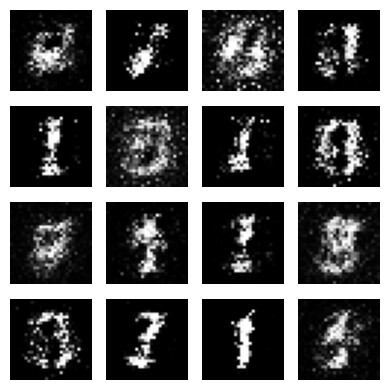

Epoch 20/50


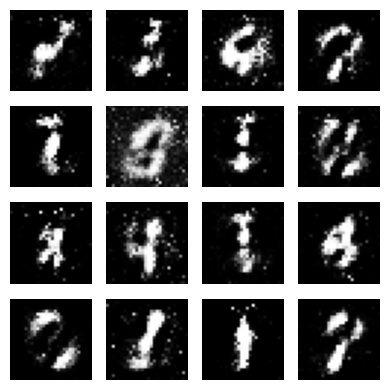

Epoch 30/50


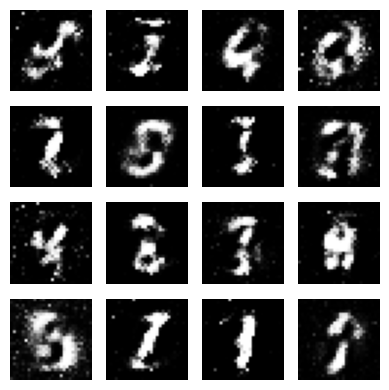

Epoch 40/50


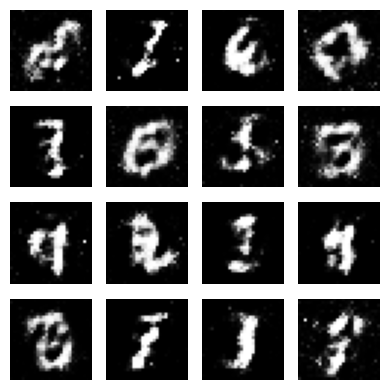

Epoch 50/50


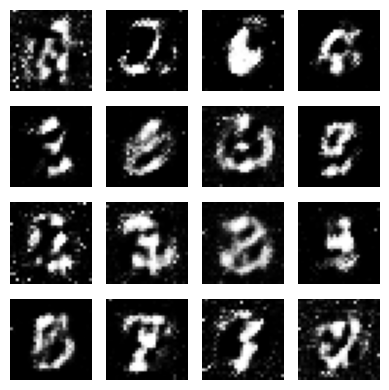

In [19]:
train(train_dataset, EPOCHS)